# PPCA in PyStan
In part 1, we managed to reproduce $x$ with our PPCA model in PyStan, but the estimates of our parameters were not accurate. Specifically, we ended up with a latent dataset $z$ in which all points were close to zero. In part 2, we will try to approach the true values of these values more accurately.

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

## indentifying the problem

Suppose we have two models in PyStan, one in which the prior over $z$ is specified and one in which it is not. Let's see how this affects the outcome of our estimates.

In [17]:
prior = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
    
    // prior over z    
    to_vector(z) ~ normal(0.0,1.0);
}
"""
ppca_pystan_prior = pystan.StanModel(model_code=prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be3b7183348a59bc1ef8563bc7f7dd59 NOW.


In [18]:
no_prior = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_pystan_no_prior = pystan.StanModel(model_code=no_prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_079f555cbce9fa855a4015bfa2e456f9 NOW.


We specify our parameters and generate some data.

In [19]:
N=10000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

And then we can optimize our parameters and latent dataset.

In [20]:
op_prior = ppca_pystan_prior.optimizing(data=ppca_dat)
op_no_prior = ppca_pystan_no_prior.optimizing(data=ppca_dat)

z_p = op_prior['z']
sigma_p = op_prior['sigma']
W_p = op_prior['W']
x_p = np.random.normal(np.matmul(W_p,z_p),sigma_p)

z_np = op_no_prior['z']
sigma_np = op_no_prior['sigma']
W_np = op_no_prior['W']
x_np = np.random.normal(np.matmul(W_p,z_p),sigma_np)

Let's compare our models with the real values and the values as found by Tipping & Bishops PPCA method.

In [21]:
ppca = PPCA()
ppca.fit(x.T, mu = np.zeros(D)[np.newaxis].T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]
x_ppca = np.matmul(W_ppca,z_ppca)
# ppca_em = PPCA()
# ppca_em.fit(x, form='em', em_calc_loglikelihood=False)
# _, sigma_ppca_em, W_ppca_em = ppca.parameters()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [22]:
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance (prior): ', sigma_p**2)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print('simulated variance: (no prior)', sigma_np**2)
print()
print('real z: ', z)
print('PPCA z: ', z_ppca)
print('simulated z (prior): ', z_p)
print('simulated z (no prior): ', z_np)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W (prior): ', W_p)
print('simulated W (no prior): ', W_np)
print()

real variance:  13.036697663539861
PPCA variance:  13.383571540445129
simulated variance (prior):  5.552551215476269
simulated variance: (no prior) 5.240741992800716

real z:  [[-0.63038784  1.31063175  1.5031181  ...  0.5822865  -0.13684139
  -0.19643038]
 [-0.58209216  0.72947002  0.38813942 ...  0.06635778  0.70574207
  -0.21299982]]
PPCA z:  [[ 1.17488197 -0.01528585 -0.68976833 ...  1.28703083  0.84145931
   0.15007942]
 [ 1.78066713 -1.12932992 -1.4139498  ... -2.436397    1.64483036
  -1.74731752]]
simulated z (prior):  [[-5.53387439e-05  6.37622504e-05  5.00181118e-06 ...  6.81427211e-05
   6.91785108e-06  3.88299444e-06]
 [-1.29137541e-04  5.46444162e-05  6.57630096e-05 ... -6.73320909e-07
  -7.15639781e-05  2.00269609e-05]]
simulated z (no prior):  [[-253.10552737  106.41280426   86.79710935 ... -115.98196512
   -86.46966327  -54.37883565]
 [ 163.25085844  -97.10125356   -3.24141793 ...  116.11659025
   -20.67941778  112.4951762 ]]

real W:  [[ 0.36747537  1.67886644]
 [-1.52

We see that the prior over $z$ causes our latent data to be very close to zero, whereas defining no prior leaves us with very large values. According to our model, $z$ is a Gaussian $\mathcal{N}(0,1)$. Let's see what latent distribution our models generate.

In [23]:
print('Model with prior: p(z) = N(z|',np.mean(z_p, axis=1),',',np.std(z_p, axis=1),')')
print('Model without prior: p(z) = N(z|',np.mean(z_np, axis=1),',',np.std(z_np, axis=1),')')

Model with prior: p(z) = N(z| [8.25068952e-07 7.18328370e-07] , [4.83143470e-05 1.00193579e-04] )
Model without prior: p(z) = N(z| [ 1.62985482 -1.62048145] , [202.5454093  150.57418121] )


The model without prior does not generate a latent dataset data adheres to its supposed form, but that was to be expected since we specified not prior. Strangely, the model with the specified prior does neither: although the mean is close to zero, the std. dev. is too! This can be explained as follows. PyStan recieves the command to optimize all parameters according to their likelihood. The original PPCA model does not estimate $z$, it merely takes its distribution into account. PyStan, in contrast, optimizes $z$ to its prior. Since $z$ comes from a zero-centered Normal dsitribution, its prior is most likely when close to zero, hence, PyStan generates $N\times M$ estimates of $z$ that are all close to zero. In turn, this is compensated by a $W$ with very large values, which is totally possible as the values of $W$ have flat priors and no restrictions. If we want PyStan to find accurate values for the other parameters, it shall be necessary to eliminate the option to optimize $z$ to its zero-mean. It is thereby important to not remove the prior over $z$ from the model entirely, as we have seen in the model without prior, as PyStan is then able to draw values for $z$ which do not comply with its Gaussian distribution either.

The plots below show that both models manage to reproduce $x$, but with very different latent datasets (note the scale on the axes).

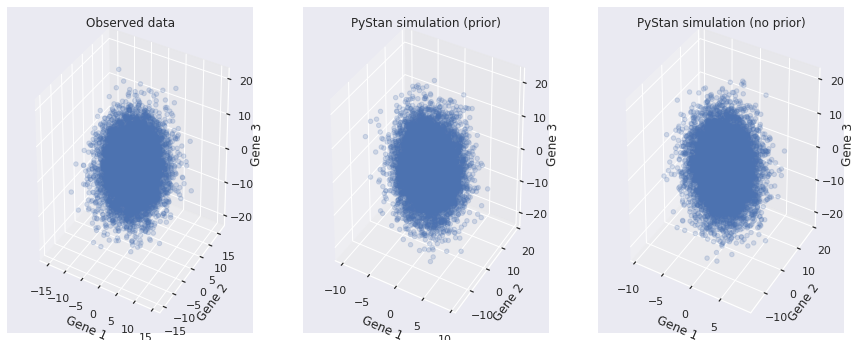

In [24]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x_p[0,:],x_p[1,:],x_p[2,:], alpha=0.2)
ax.set_title('PyStan simulation (prior)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_np[0,:],x_np[1,:],x_np[2,:], alpha=0.2)
ax.set_title('PyStan simulation (no prior)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

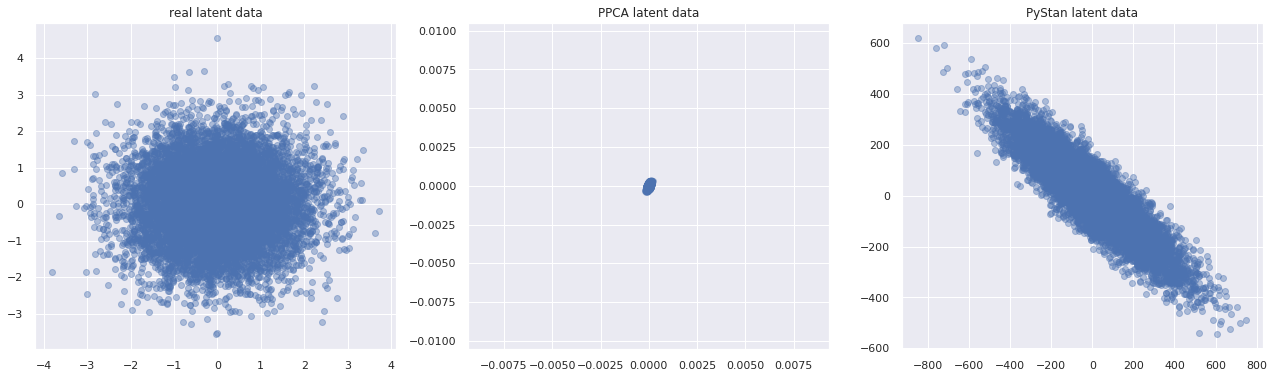

In [25]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_p[0,:], z_p[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z_np[0,:], z_np[1,:], alpha=0.4)
ax.set_title('PyStan latent data')
plt.show()

## Solving the problem

Our first try to work around the minimized values of $z$ is by giving the model a pre-made set $z$ to compute $\sigma$ and $W$. With those parameters then, we can try to find the actual values of $z$.

In [26]:
ppca_WS = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
    matrix[M,N] z;  // latent data
}


parameters{
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_pystan_WS = pystan.StanModel(model_code=ppca_WS)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80e580d992e22519b15a545935df3a15 NOW.


In [27]:
N=100000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)

And then we can optimize our parameters and latent dataset.

In [28]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T, 'z':np.random.normal(0,1, size=(M,N))}
op = ppca_pystan_WS.optimizing(data=ppca_dat)

sigma_sim = op['sigma']
W_sim = op['W']

print('real std. dev: ', sigma)
print('simulated std. dev.: ', sigma_sim)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real W: ', W)
print('simulated W (prior): ', W_sim)
print()

real std. dev:  1.0947377117929964
simulated std. dev.:  1.500341422390389

real W:  [[ 0.15964353 -1.04228088]
 [ 0.82424207  0.03405566]
 [ 0.20511619  1.14235664]]
simulated W (prior):  [[-0.00954498 -0.00221165]
 [-0.00358094  0.00239351]
 [ 0.00767361  0.00314351]]



In [29]:
ppca_z = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}


parameters{
    matrix[M,N] z;  // latent data
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
    
    // prior over z    
    to_vector(z) ~ normal(0.0,1.0);
}
"""
ppca_pystan_z = pystan.StanModel(model_code=ppca_z)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47c749582d841a90ee7f2c397da51839 NOW.


In [30]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T, 'W':W_sim, 'sigma':sigma_sim}
op = ppca_pystan_z.optimizing(data=ppca_dat)

z_sim = op['z']
x_sim = np.random.normal(np.matmul(W_sim,z_sim),sigma_sim)

print('real z: ', z)
print('simulated z: ', z_sim)

real z:  [[ 0.38580134  0.43207175  0.08516408 ... -0.39646462  1.14449719
   0.5497146 ]
 [ 0.3043988   1.68553072 -0.47090915 ... -0.35641759  1.11252438
   0.58076919]]
simulated z:  [[ 1.27235652e-02  4.73298688e-04  7.45867972e-03 ... -2.43610941e-03
   1.03301355e-02  1.79123473e-03]
 [ 2.60964809e-03 -5.49215977e-04  1.96057875e-03 ...  4.47250076e-05
   3.61090412e-03  1.64331982e-03]]


In [31]:
ppca = PPCA()
ppca.fit(x.T, mu = np.zeros(D)[np.newaxis].T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]
x_ppca = np.matmul(W_ppca,z_ppca)
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance: ', sigma_sim**2)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real z: ', z)
print('PPCA z: ', z_ppca)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W: ', W_sim)
print()
print('real WW^T: ', np.matmul(W,W.T))
print('PPCA WW^T: ', np.matmul(W_ppca,W_ppca.T))
# print('PPCA W (em): ', W_ppca_em)
print('simulated WW^T: ', np.matmul(W_sim, W_sim.T))
print()

real variance:  1.1984506576217657
PPCA variance:  1.1952873496239593
simulated variance:  2.2510243837404156

real z:  [[ 0.38580134  0.43207175  0.08516408 ... -0.39646462  1.14449719
   0.5497146 ]
 [ 0.3043988   1.68553072 -0.47090915 ... -0.35641759  1.11252438
   0.58076919]]
PPCA z:  [[ 1.22958723  0.1720141   0.61938102 ... -0.41005832  0.6519498
  -0.05117879]
 [ 0.37691963  0.58880245  0.19520247 ...  0.85823236  0.1142727
  -1.59999418]]
simulated z:  [[ 1.27235652e-02  4.73298688e-04  7.45867972e-03 ... -2.43610941e-03
   1.03301355e-02  1.79123473e-03]
 [ 2.60964809e-03 -5.49215977e-04  1.96057875e-03 ...  4.47250076e-05
   3.61090412e-03  1.64331982e-03]]

real W:  [[ 0.15964353 -1.04228088]
 [ 0.82424207  0.03405566]
 [ 0.20511619  1.14235664]]
PPCA W:  [[-1.03994479  0.64232726]
 [-1.0896695  -0.5643854 ]
 [ 0.38492643  0.13766613]]
simulated W:  [[-0.00954498 -0.00221165]
 [-0.00358094  0.00239351]
 [ 0.00767361  0.00314351]]

real WW^T:  [[ 1.11183548  0.09608935 -1.1

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


As we can see, this method is actually less reliable than the original, so this is not our answer.

In [32]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}
op_prior = ppca_pystan_prior.optimizing(data=ppca_dat)
z_p = op_prior['z']
sigma_p = op_prior['sigma']
W_p = op_prior['W']
x_p = np.random.normal(np.matmul(W_p,z_p),sigma_p)

In [33]:
print(sigma_p)
print(W_p)

0.6312243197294491
[[ 401.21716221  150.73004553]
 [ 238.35281673 -373.74412432]
 [-325.30361133 -328.86919254]]
